In [1]:
import sys

sys.path.insert(1, 'K:/UZH/Spring 24/Sem Project/kneedeeppose')


In [2]:
import pyvista
import torch
from diffdrr.drr import DRR
from diffdrr.visualization import drr_to_mesh, img_to_mesh

from diffpose.deepfluoro import DeepFluoroDataset
from diffpose.visualization import fiducials_to_mesh, lines_to_mesh


## If running Jupyter remotely, run the following...

pyvista.start_xvfb()
pyvista.global_theme.trame.server_proxy_enabled = True
pyvista.global_theme.trame.server_proxy_prefix = "/proxy/"


In [3]:
pyvista.set_jupyter_backend("trame")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Initialize DiffDRR for Patient 1
SUBSAMPLE = 6.410714285714286
specimen = DeepFluoroDataset(id_number=1)
height = int((1536 - 100) / SUBSAMPLE)
delx = 0.194 * SUBSAMPLE

drr = DRR(
    specimen.volume,
    specimen.spacing,
    sdr=specimen.focal_len / 2,
    height=height,
    delx=delx,
    x0=specimen.x0,
    y0=specimen.y0,
    reverse_x_axis=True,
    bone_attenuation_multiplier=2.5,
).to(device)

In [5]:
_, pose = specimen[69]
rotations = pose.get_rotation().to(device)
translations = pose.get_translation().to(device)

In [13]:
specimen[69][0].shape

torch.Size([1, 1, 1436, 1436])

In [7]:
# Extract a mesh from the CT
ct = drr_to_mesh(drr, method="surface_nets", threshold=145, verbose=True)

# Make meshes for the camera and detector plane and
# convert the DRR into a texture for the detector plane
camera, detector, texture, principal_ray = img_to_mesh(
    drr, rotations, translations, "matrix"
)

# Compute the locations of 3D fiducials and projected 2D fiducials
fiducials_3d, fiducials_2d = fiducials_to_mesh(
    specimen,
    rotations,
    translations,
    detector=detector,
    parameterization="matrix",
)

# Draw lines from the camera to the 2D fiducials
lines = lines_to_mesh(camera, fiducials_2d)

Performing Labeled Surface Extraction: 100%|██████████[00:00<00:00]
Finding and Labeling Connected Regions.: 100%|██████████[00:00<00:00]
Smoothing Mesh using Taubin Smoothing: 100%|██████████[00:01<00:00]
Filling Holes: 100%|██████████[00:00<00:00]
Cleaning: 100%|██████████[00:00<00:00]


## Rendering a single X-ray in an interactive window

Exporting a notebook to HTML does not also automatically catch the PyVista plots, so the interactive plot has been manually saved to HTML and loaded.

In [8]:
plotter = pyvista.Plotter()
plotter.add_mesh(ct)
plotter.add_mesh(camera, show_edges=True)
plotter.add_mesh(detector, texture=texture)
plotter.add_mesh(principal_ray, color="red")
plotter.add_mesh(
    fiducials_3d,
    color="blueviolet",
    point_size=7.5,
    render_points_as_spheres=True,
)
plotter.add_mesh(
    fiducials_2d,
    color="lime",
    point_size=5,
    render_points_as_spheres=True,
)
for line in lines:
    plotter.add_mesh(line, color="lime")

plotter.add_axes()
plotter.add_bounding_box()

# plotter.show()  # If running Jupyter locally
# plotter.show(jupyter_backend="server")  # If running Jupyter remotely
plotter.export_html("render.html")

In [9]:
from IPython.display import IFrame

IFrame("render.html", height=500, width=749)

## Rendering multiple X-rays in a static window

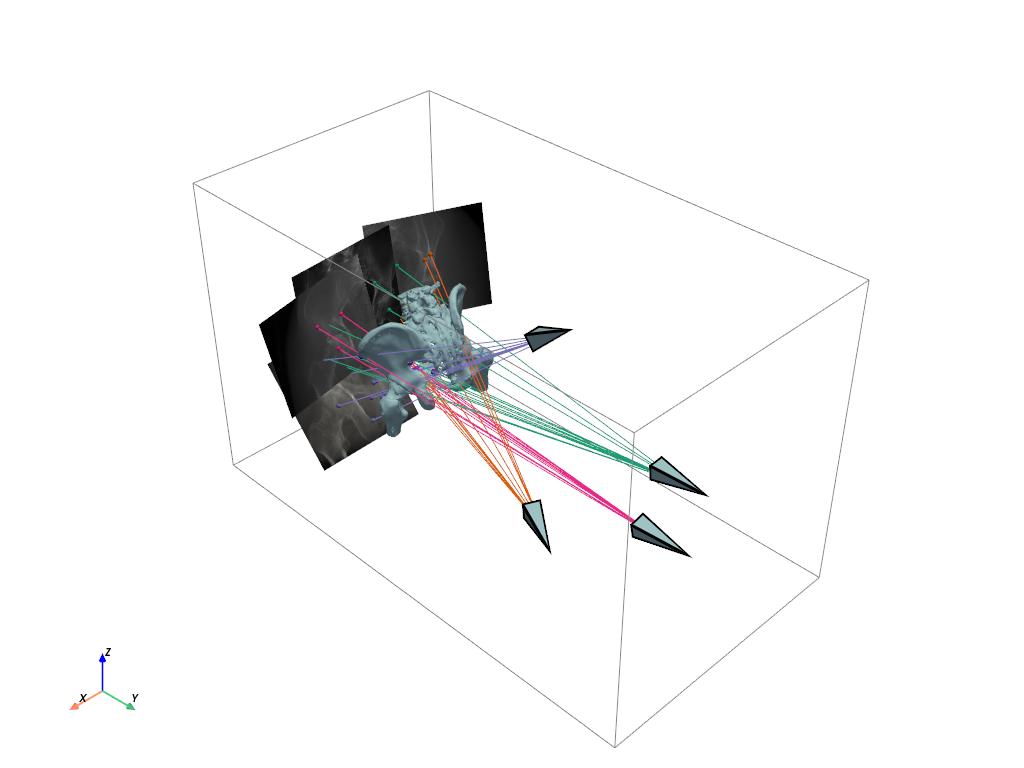

In [10]:
# Initialize the plot with the CT and 3D fiducials (shared across all plots)
plotter = pyvista.Plotter()
plotter.add_mesh(ct)
plotter.add_mesh(
    fiducials_3d,
    color="blueviolet",
    point_size=7.5,
    render_points_as_spheres=True,
)

# Render a subset of the X-rays
for idx, color in zip([0, 2, 69, 100], ["#1b9e77", "#d95f02", "#7570b3", "#e7298a"]):
    _, pose = specimen[idx]
    rotations = pose.get_rotation().to(device)
    translations = pose.get_translation().to(device)

    camera, detector, texture, _ = img_to_mesh(
        drr, rotations, translations, parameterization="matrix"
    )
    _, fiducials_2d = fiducials_to_mesh(
        specimen, rotations, translations, detector=detector, parameterization="matrix"
    )
    lines = lines_to_mesh(camera, fiducials_2d)

    plotter.add_mesh(camera, show_edges=True, line_width=3)
    plotter.add_mesh(detector, texture=texture)
    plotter.add_mesh(
        fiducials_2d,
        color=color,
        point_size=5,
        render_points_as_spheres=True,
    )
    for line in lines:
        plotter.add_mesh(line, color=color)

plotter.add_axes()
plotter.add_bounding_box()
plotter.show(jupyter_backend="static")